In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import wfdb
import ast
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

frequence = 100 # For testing purposes we are going to use the 100 Hz data. The 500 Hz data must be used only in the supercomputer
time = 10 # The recorded time of the data in seconds
sequence_features = 12 # how much features from the ECG we are observing
input_nums = frequence * sequence_features * time # this is the amount of data we are going to feed

# testing with 4 middle layers, doesn't produced different results so we are left with only 3 middle layers
# h1_middle_layer_neurons = int(input_nums * 0.75) # here we reduce the layers to half the size of the data we use
# h2_middle_layer_neurons = int(input_nums * 0.5) # and for the second hidden layer we use quater the data size
# h3_middle_layer_neurons = int(input_nums * 0.25) # and for the second hidden layer we use quater the data size
# h4_middle_layer_neurons = int(input_nums * 0.1) # and for the second hidden layer we use quater the data size

h1_middle_layer_neurons = int(input_nums / 2) # here we reduce the layers to half the size of the data we use
h2_middle_layer_neurons = int(input_nums / 4) # and for the second hidden layer we use quater the data size

# age range to filter the patients data for better accuracy and less data manipulations
min_age = 35
max_age = 50

path = '/home/yuli/py-venv-1/ptb-xl-data/'
sampling_rate=frequence

# Create a new model class that inherits nn.Module
class Model(nn.Module):
    # input layer with 12 features of the ptb-xl
    # hidden layer h1 with number of neurons
    # hidden layer h2 with other number of neurons
    # ->> output with 2 classes of sick and healthy
    def __init__(self,
                in_features=input_nums,
                h1=h1_middle_layer_neurons,
                h2=h2_middle_layer_neurons, 
                # h3=h3_middle_layer_neurons,
                # h4=h4_middle_layer_neurons,
                out_features=2):
    # def __init__(self, in_features=12000, h1=6000, h2=3000, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        # self.fc3 = nn.Linear(h2, h3)
        # self.fc4 = nn.Linear(h3, h4)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        x = self.out(x)

        return x
    
# Pick manual seed for randomization
torch.manual_seed(29)

# Instantiate our model

model = Model()

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [4]:
# filtering the patients by age, and only if the result is validated by human
# for higher accuracy
Y = Y[Y['age'].between(min_age, max_age)]
Y = Y[(Y['validated_by_human'] == True)]
# Y = Y[(Y['strat_fold'] == 10)]

# change filter by report text
# Y = Y[(Y.report == 'sinusrhythmus normales ekg')]


In [5]:
# Y.report

In [6]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [7]:
def aggregate_diagnostic(y_dic: dict):
    tmp = []
    dic_keys = y_dic.keys()
    if 'NORM' in dic_keys and 'SR' in dic_keys:
        tmp.append(0.0)
    else:
        tmp.append(1.0)

    return list(set(tmp))

def aggregate_diagnostic_by_report(report: str):
    tmp = []
    if report == 'sinusrhythmus normales ekg': # all patients having normal sinus rythm are considered healthy
        # all other patients with some deviations from the norm are considered sick
        tmp.append(0.0)
    else:
        tmp.append(1.0)

    return list(set(tmp))

# Apply diagnostic superclass
# Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y['diagnostic_superclass'] = Y.report.apply(aggregate_diagnostic_by_report)



In [8]:
# Y['diagnostic_superclass']

In [9]:
# Creating two temporarly X and y matrices, we are going to use to apply further data
# manipulations to ensure only valid data is used for the training process
# this will give us high level of predictions
X_tmp = X
y_tmp = Y.diagnostic_superclass.values

In [10]:
X_f = []
y_f = []

# normalizing the data
for i in range(len(X_tmp)):
    if (len(y_tmp[i]) > 0):
        tmparr = np.array(X_tmp[i])
        tmparr = np.concatenate(tmparr)
        X_f.append(tmparr)
        y_f.append(y_tmp[i][0])

X_tmp = X_f
y_tmp = y_f


In [11]:
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_tmp, test_size=0.05, random_state=29)
X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_tmp, test_size=0.1, random_state=29)

In [12]:
# Convert X features to float tensors
X_train = torch.FloatTensor(np.asarray(X_train))
X_test = torch.FloatTensor(np.asarray(X_test))
# convert the y labels to tensors long
# y_train = torch.LongTensor(np.concatenate(y_train))
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [13]:
# set the criterion/deviation of model to measure the error
# or how far off the predictions are from the data
criterion = nn.CrossEntropyLoss()

# Choose Adam optimizer - lr is learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001 )
# optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)


In [ ]:
# Train our model
epochs = 100 # we want to print the result from the 100th epoch as well so we are doing 100 + 1 iterations
loses = []

for i in range(epochs):
    # go forward and get a prediction
    y_pred = model.forward(X_train)

    # measure the loss/error - gonna be high at first
    loss = criterion(y_pred, y_train)

    # keep track of our loses
    loses.append(loss.detach().numpy())

    # print every 10 epochs
    if (i+1) % 10 == 0 or i == 0:
        print(f'Epoch: {i+1} and loss is: {loss:.12f}')

    # Do some backpropagation: take the error rate of forward propagation and feed it back
    # thru the network to fine tune the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 1 and loss is: 0.720876753330
Epoch: 2 and loss is: 0.694193601608
Epoch: 10 and loss is: 0.521477997303
Epoch: 20 and loss is: 0.381419211626
Epoch: 30 and loss is: 0.298771500587
Epoch: 40 and loss is: 0.251381456852
Epoch: 50 and loss is: 0.219225674868
Epoch: 60 and loss is: 0.192791596055
Epoch: 70 and loss is: 0.169616430998
Epoch: 80 and loss is: 0.149109914899
Epoch: 90 and loss is: 0.130919724703
Epoch: 100 and loss is: 0.114808641374


In [15]:
print(f'first error is: {loses[0]:.7f} and last error is {loses[epochs-1]:.7f}')

first error is: 0.7208768 and last error is 0.1148086


Text(0.5, 0, 'Epochs')

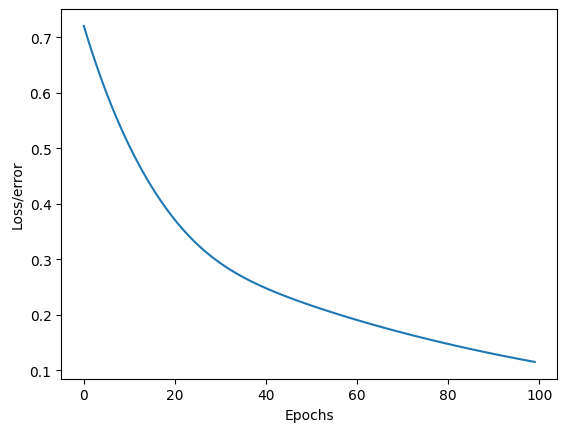

In [16]:
plt.plot(range(epochs), loses)
plt.ylabel('Loss/error')
plt.xlabel('Epochs')

In [17]:
# Evaluate model on test data set - validation

with torch.no_grad(): # no_grad turn off back propagation so we only test data on the model
    y_eval = model.forward(X_test) # X_test is our test set. y_eval are the predictions of the model
    loss = criterion(y_eval, y_test) # this is our loss - how much of the train data has inaccurate results after evaluating

loss


tensor(0.2758)

In [18]:
loss

tensor(0.2758)

In [19]:
y_test
# Y
# Y.scp_codes

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
correct = 0
incorrect = 0

with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.forward(data)

        # will tell us wether or not our network think the patient is sick
        # print(f'{i} : {str(y_val)} - {y_val.argmax().item()}  - {y_test[i]}')

        if (y_val.argmax().item() == y_test[i]):
            correct += 1
        else:
            incorrect += 1

total = correct + incorrect
print(f'correct: {correct}, incorrect: {incorrect}, total: {total}')
print(f'Total correct rate: {((correct / (total)) * 100):.2f} %')
print(f'Total incorrect rate: {((incorrect / (total)) * 100):.2f} %')

0 : tensor([-1.6686,  1.6422]) - 1  - 1
1 : tensor([-1.9736,  1.9699]) - 1  - 1
2 : tensor([-0.8291,  0.8228]) - 1  - 1
3 : tensor([-1.1216,  1.0861]) - 1  - 1
4 : tensor([-2.8468,  2.8882]) - 1  - 1
5 : tensor([-1.1345,  1.1590]) - 1  - 1
6 : tensor([-1.5128,  1.5240]) - 1  - 1
7 : tensor([-1.2894,  1.2906]) - 1  - 1
8 : tensor([-1.0006,  1.0053]) - 1  - 1
9 : tensor([-1.4603,  1.4695]) - 1  - 1
10 : tensor([-1.4789,  1.4541]) - 1  - 1
11 : tensor([-1.1921,  1.2258]) - 1  - 1
12 : tensor([-1.8030,  1.8286]) - 1  - 1
13 : tensor([-1.3714,  1.3626]) - 1  - 1
14 : tensor([-2.2642,  2.2668]) - 1  - 1
15 : tensor([-1.4974,  1.4931]) - 1  - 0
16 : tensor([-2.1771,  2.1921]) - 1  - 1
17 : tensor([-0.9337,  0.9658]) - 1  - 1
18 : tensor([-1.5232,  1.5046]) - 1  - 1
19 : tensor([-2.2234,  2.2253]) - 1  - 1
20 : tensor([-1.2736,  1.2967]) - 1  - 1
21 : tensor([-1.1651,  1.1690]) - 1  - 1
22 : tensor([-1.9116,  1.9563]) - 1  - 1
23 : tensor([-0.8735,  0.8747]) - 1  - 1
24 : tensor([-0.9491,  0.9

In [22]:
torch.save(model.state_dict(), 'ptb-xl-trained-seq100-age35-50.pt')

In [23]:
new_model = Model()
new_model.load_state_dict(torch.load('ptb-xl-trained-seq100-age35-50.pt'))

<All keys matched successfully>

In [ ]:
correct = 0
incorrect = 0

with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = new_model.forward(data)

        if (y_val.argmax().item() == y_test[i]):
            correct += 1
        else:
            incorrect += 1

total = correct + incorrect
print(f'correct: {correct}, incorrect: {incorrect}, total: {total}')
print(f'Total correct rate: {((correct / (total)) * 100):.2f} %')
print(f'Total incorrect rate: {((incorrect / (total)) * 100):.2f} %')

correct: 253, incorrect: 19, total: 272
Total correct rate: 93.01 %
Total incorrect rate: 6.99 %
